#### Q1: How does a NB model interprets count values?


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
import preprocessing as pp

In [2]:
thesaurus = {
    "services":"network web",
    "service":"network web",
    "client":"network",
    "table":"database",
    "thread":"concurrency",
    "id":"database",
    "server":"network",
    "call":" ",
    "action":"concurrency",
    "cluster":"network node",
    "node":"network",
    "nodes":"network",
    "job":"concurrency",
    "jobs":"concurrency",
    "job1":"concurrency",
    "job2":"concurrency",
    "coordinator":"concurrency",
    "nodes":"network",
    "block":"io",
    "get":"network",
    "runtest":"test",
    "row":"database",
    "enqueue":"stack",
    "oozie":" ",
    "coord":" ",
    "url":"web network",
    "geturl":"web network",
    "assert":" ",
    "fs":"io file",
    "assertequals":" ",
    "assertsame":" ",
    "assertthat":" ",
    "asserttrue":" ",
    "assertnotnull":" ",
    "assertnull":" ",
    "assertfalse":" ",
    "testscan":" ",
    "run":"concurrency",
    "file":"file io",
    "http":"web network",
    "httprequest":"web network",
    "createrequest":"web network",
    "request":"web network",
    "bytes":"database",
    "tobyte":"database",
    "tobytes":"database",
    "tostring":"string",
    "foo":" ",
    "value":" ",
    "connection":"network database",
    "createtable":"database",
    "createfile":"file io",
    "mkdir":"io",
    "xml":"file",
    "sleep":"concurrency",
    "insert":"database",
    "log":"file io",
    "close":"file network database",
    "currenttimemillis":"time",
    "timeunit":"time",
    "mock":" ",
    "record":"database",
    "getfilesystem":"file io",
    "workflow":"concurrency",
    "worklfow":"concurrency",
    "system":"io",
    "controller":"concurrency",
    "runtestscenarioconnect":" ",
    "readjsonfile":"io",
    "test1":" ",
    "test":" ",
    "open":"file io",
    "gettime":"time",
    "function":" ",
    "getendpointbean":" ",
    "wf":" ",
    "dir":"io",
    "path":"file io",
    "mtfs":" ",
    "the":" ",
    "name":" ",
    "have":" ",
    "not":" ",
    "is":" ",
    "user":" ",
    "be":" ",
    "off":" ",
    "been":" ",
    "context":" ",
    "ok":" ",
    "next":" ",
    "len":" ",
    "in":" ",
    "to":" ",
    "end":" ",
    "and":" ",
    "of":" ",
    "equals":" ",
    "should":" ",
    "createconnection":"network",
    "count":" ",
    "tablename":"database",
    "column":"database",
    "serverport":"network",
    "getsockettimeout":"network",
    "host":"network",
    "pool":"network database",
    "assertjob":" ",
    "gethttpconnectioncount":"web network",
    "getcolumn":"database",
    "getcolumns":"database",
    "columnnames":"database",
    "createcolumn":"database",
    "hostname":"network",
    "host1":"network",
    "tostrings":"string",
    "testutils":" ",
    "testfile":"io",
    "rows":"database",
    "method":" "
}

In [3]:
def document_to_synonims(document):
    '''Replaces tokens of a document by its synonims/semantic related words.
        Synset_option: 1 = synonyms 
                       2 = semantic related words'''
    
    synset = []
    for word in document:
        terms = thesaurus.get(word)    
        if bool(terms):   
            synset.append(terms)
        else:
            synset.append(word)
            
    return ' '.join(map(str, synset))


def preprocess_tokens(data):
    '''Tokenizes each document before replacing synonims.
        Returns: list of processed documents'''
    
    processed_tokens = [] 
    for row in data['clean_token']:
        tokenized_row = word_tokenize(row)
        processed_row = document_to_synonims(tokenized_row)
        processed_tokens.append(processed_row)
        
    return processed_tokens

def preprocess(token):
    token = str(token) 
    token_lowered = token.lower()
    
    #token_lowered = re.sub(r'(\brow\b)|(\btable\b)|(\binsert\b)|(\bid\b)', 'dbms', token_lowered)
    
    url_pattern = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    token_url = re.sub(url_pattern, 'urllink', token_lowered)
    
    date_pattern = '([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))|([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))|([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))'
    token_dates = re.sub(date_pattern, 'date', token_url)
    
    ip_pattern = '(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])'
    token_ip = re.sub(ip_pattern, ' ipaddrezz ', token_dates)
    
    token_num = re.sub(r'\b[0-9]+\b', ' ', token_ip)
    
    special_character_pattern = '[^A-Za-z0-9]+'
    token_char = re.sub(special_character_pattern, ' ', token_num)
    
    return token_char

### Loading data

In [4]:
msr_data = pd.read_csv('data/msr_dataset.csv', encoding = 'ANSI', index_col=False)
msr_data['clean_token'] = msr_data['token'].map(lambda s:preprocess(s)) 
msr_data['processed_token'] = preprocess_tokens(msr_data)
y_msr = msr_data['class']
msr = msr_data.drop(columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(msr_data['processed_token'], y_msr, 
                                                    train_size=0.8, random_state=33, shuffle=True)

In [5]:
X_train

1407    check for resolved conf e concurrency network ...
865     add network def   invalid execution file io on...
1528    property had invalid int   but was read succes...
328     a a cc e e gg i i m m q q u u y y kk oo ss ww ...
1690    network web network database start network add...
                              ...                        
57        equal   false equal   true network join jms ...
2706    network instances set network     network inst...
578     network web network database network address a...
1752    monotonic now increment   network file io warn...
2439    aap sg qaaad 0o eaaaa kbaaaap sg qaaad 0o eaaa...
Name: processed_token, Length: 2243, dtype: object

In [6]:
new_data = pd.read_csv('data/new_dataset.csv')
new_data['clean_token'] = new_data['token'].map(lambda t:preprocess(t)) 
new_data['processed_token'] = preprocess_tokens(new_data)
y_new = new_data['class']
new_data = new_data.drop(columns=['class'])

In [13]:
def plot_word_count(data, n):
    counter = CountVectorizer()
    bow = counter.fit_transform(data)
    sparse_matrix = pd.DataFrame(bow.toarray(), columns = counter.get_feature_names())
    counts = sparse_matrix.sum().sort_values(ascending=False)

    sns.barplot(x=counts.index[:n], y=counts.values[:n], palette='Blues_d')
    plt.xticks(rotation=90)
    plt.title('Word frequency in corpus')

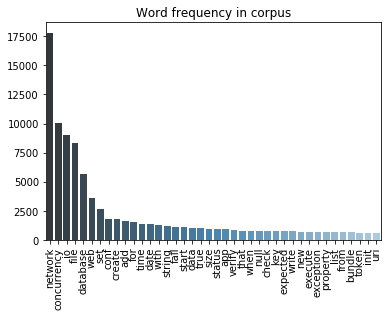

In [74]:
plot_word_count(msr_data['processed_token'], n=40)

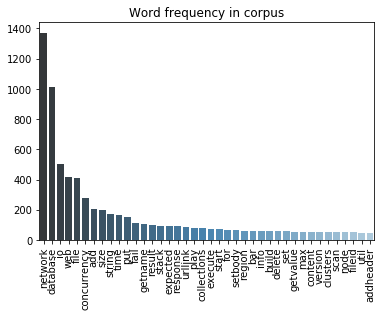

In [75]:
plot_word_count(new_data['processed_token'], n=40)

In [ ]:
new_data['processed_token)

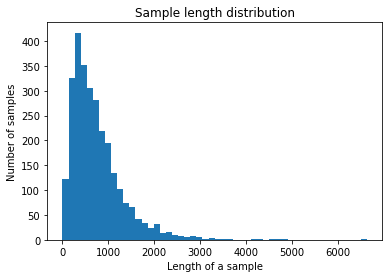

In [76]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    
plot_sample_length_distribution(msr_data['processed_token'])

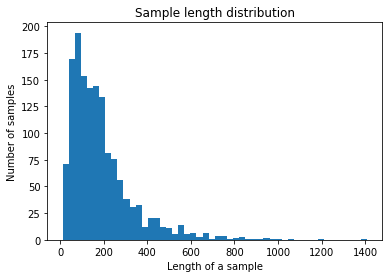

In [77]:
plot_sample_length_distribution(new_data['processed_token'])

In [78]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

get_num_words_per_sample(msr_data['processed_token'])

78.0

In [79]:
get_num_words_per_sample(new_data['processed_token'])

15.0

### Building model

In [11]:
from sklearn.model_selection import cross_val_score

text_clf1 = Pipeline([
                      ('vectorizer', CountVectorizer(stop_words='english')),
                      ('model', MultinomialNB())])

scores = cross_val_score(text_clf1, msr_data['processed_token'], y_msr, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.02)


In [54]:
text_clf1['vectorizer'].vocabulary_

{'check': 1538,
 'resolved': 9492,
 'conf': 1927,
 'concurrency': 1915,
 'network': 7765,
 'case': 1450,
 'io': 6253,
 'property': 8814,
 'create': 2304,
 'element': 3329,
 'list': 6968,
 'dry': 3179,
 'pull': 8875,
 'deps': 2901,
 'print': 8716,
 'stack': 10774,
 'trace': 13632,
 'child': 1626,
 'parse': 8401,
 'file': 3864,
 'missing': 7460,
 'dependencies': 2889,
 'fail': 3754,
 'children': 1639,
 'namespace': 7718,
 'command': 1820,
 'utils': 13974,
 'add': 339,
 'database': 2614,
 'waiting': 14203,
 'make': 7206,
 'sure': 11100,
 'met': 7377,
 'configuration': 1941,
 'data': 2611,
 'app': 601,
 'bean': 1043,
 'input': 6119,
 'matd': 7299,
 'hcat': 5673,
 'miss': 7457,
 'newaction': 7773,
 'message': 7369,
 'e1': 3244,
 'set': 10079,
 'e2': 3248,
 'local': 7017,
 'available': 905,
 'config': 1932,
 'elem': 3328,
 'got': 5485,
 'eaction': 3257,
 'gettestcasedir': 5321,
 'createactionelement': 2307,
 'elementlist': 3335,
 'dryruncoord': 3181,
 'testdryrunpulldeps': 11957,
 'printstac

### Evaluating NB model on new data

In [82]:
new_preds = text_clf1.predict(new_data['processed_token'])
print(classification_report(y_new, new_preds))
print('f1', f1_score(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.61      0.42      0.50       724
           1       0.56      0.74      0.64       737

    accuracy                           0.58      1461
   macro avg       0.59      0.58      0.57      1461
weighted avg       0.59      0.58      0.57      1461

f1 0.6383981154299174


In [83]:
new_data['processed_token'][1000:1050]

1000    getresource mapsubresources setuserpredicate g...
1001    web network handler getresource   setuserpredi...
1002    urllink getresource setuserpredicate setresour...
1003    getresource setuserpredicate setresourceproper...
1004    schema getresourcedefinition put property2 pro...
1005    schema getresourcedefinition put property4 pro...
1006    schema getresourcedefinition put property2 net...
1007    schema getresourcedefinition put testaddproper...
1008    schema components testaddproperty subproperty ...
1009    mapresourceids setuserpredicate getresourcedef...
1010    mapresourceids setuserpredicate getresourcedef...
1011    mapresourceids getresourcedefinition getids pu...
1012    mapresourceids getresourcedefinition getids pu...
1013    getname mapresourceids getresourcedefinition g...
1014    web network actionname compaction web network ...
1015    web network resourcedef web network resultseri...
1016    bar testaddargument addargument   string   str...
1017    addarg

In [84]:
new_data['processed_token'][444]

'localhost testhttpcreateconnection conn isopen network network database web network network   network network'

In [62]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        print(coef_2, fn_2)
        
show_most_informative_features(text_clf1['vectorizer'], text_clf1['model'])

-4.061483520991148 network
-4.297190868023899 concurrency
-4.680491978144255 io
-4.719624747933008 file
-4.996350638438239 database
-5.206692707564368 file io
-5.700523289009892 web
-5.854858760485094 concurrency concurrency
-5.972075979531789 network web
-6.0867728731363036 set
-6.231317851018478 date
-6.313798337589678 network database
-6.378268624958331 conf
-6.380454418178311 add
-6.453048640148098 create
-6.540273943761712 time
-6.601139287745809 app
-6.6457771025978705 io file
-6.676192191462309 start
-6.677663862073764 web network
-6.703019433695452 concurrency network
-6.72285227292837 database concurrency
-6.743086426292338 concurrency database
-6.758934618532362 status
-6.7637384708450075 data
-6.823260169804364 file network
-6.87392602725115 fail
-6.934886727040837 network network
-6.963874263914089 network file
-6.971748320344995 bundle
-6.999806273140153 string
-7.030768498744119 true
-7.039189601140528 network concurrency
-7.0498166937148135 add database
-7.06705850014932

### RandomForest

In [82]:
from sklearn.ensemble import RandomForestClassifier

text_clf2 = Pipeline([
    ('vectorizer', CountVectorizer(max_features=1000)),
    ('model', RandomForestClassifier())])

text_clf2.fit(X_train, y_train)
preds = text_clf2.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       283
           1       0.96      0.93      0.94       278

    accuracy                           0.94       561
   macro avg       0.94      0.94      0.94       561
weighted avg       0.94      0.94      0.94       561



In [83]:
importances = pd.DataFrame(text_clf2['model'].feature_importances_, 
                           index = text_clf2['vectorizer'].get_feature_names(),
                           columns=['importance']).sort_values('importance', ascending=False)

importances[:15]

,importance
concurrency,0.046942
database,0.037555
network,0.030608
node,0.016129
getid,0.015980
dfs,0.013551
web,0.011662
file,0.011610
getstatus,0.011525
app,0.010616


Text(0, 0.5, 'Token')

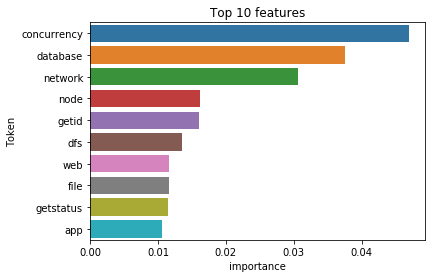

In [84]:
sns.barplot(y=importances.index[:10], x=importances['importance'][:10])
plt.title('Top 10 features')
plt.ylabel('Token')

### Evaluating RF model on new data

In [44]:
new_preds = text_clf2.predict(new_data['processed_token'])
print(classification_report(y_new, new_preds))
print('f1', f1_score(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       724
           1       0.78      0.06      0.11       737

    accuracy                           0.52      1461
   macro avg       0.64      0.52      0.39      1461
weighted avg       0.64      0.52      0.39      1461

f1 0.11320754716981132


In [28]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(new_data['processed_token'], y_new, 
                                                    train_size=0.8, random_state=33, shuffle=True)


text_clf3 = Pipeline([
    ('vectorizer', CountVectorizer(max_features=1000)),
    ('model', RandomForestClassifier())])

text_clf3.fit(X_train, y_train)
preds = text_clf3.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       143
           1       0.85      0.93      0.89       150

    accuracy                           0.88       293
   macro avg       0.89      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



In [29]:
importances = pd.DataFrame(text_clf3['model'].feature_importances_, 
                           index = text_clf3['vectorizer'].get_feature_names(),
                           columns=['importance']).sort_values('importance', ascending=False)

importances[:15]

,importance
file,0.024835
test,0.023914
concurrency,0.022617
network,0.019406
database,0.016835
transferkind,0.015502
mtfs,0.015385
getendpointbean,0.013634
time,0.012605
io,0.011819
